In [1]:
import pandas as pd
import numpy as np
import math
# import nltk
# nltk.download('punkt')
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from scipy.optimize import root
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Ignore certain warnings:
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Preprocessing and Cleaning

In [3]:
# Loading our data.
df = pd.read_csv('./data_source/datasource.csv', delimiter=';')

#drop the columns that will not be needed.
df = df.drop(df.columns[[0,6,7,8,10,11,12,13,14]], axis=1)

#clean our text a bit.
def cleanAscii(text):
       return ''.join(i for i in text if ord(i) < 128)

def load_data(df):
    #Combine exp and edu - Combine into candidate information.
    #Combine hab and v_tit - Combine into job advert information.
    #Drop exp,edu,hab,and v_tit
    
    
    df['Candidate_Info'] = df["exp"].astype(str) + df["edu"].astype(str).values
    df['Job_Advert_Info'] = df["hab"].astype(str) + df["v_tit"].astype(str).values
    
    # candidate
    candidate_info = df['Candidate_Info'].astype(str)
    job_advert_info = df['Job_Advert_Info'].astype(str)
    
    # combined: to get the tokensimport pandas as pd
    df['Combined'] = df['Candidate_Info'] + df['Job_Advert_Info']
    labels = pd.to_numeric(df['target_zero_one'].values)
    
    # We will also clean the text a bit
    candidate_info = df['Candidate_Info'].apply(cleanAscii)
    job_advert_info = df['Job_Advert_Info'].apply(cleanAscii)
    df['Combined'] = df['Combined'].apply(cleanAscii)
    
    
    return candidate_info, job_advert_info, labels

candidate_info, job_advert_info, labels = load_data(df)
candidate_info = list(candidate_info)
job_advert_info = list(job_advert_info)
combined = candidate_info + job_advert_info

In [4]:
candidate_info[1] 
# --> Candidates size 300 
# --> combined[0] to combined[300] == candidates info.

'Analista de Sistemas Snior,Senior Windows Phone Developer,Analista de Desenvolvimento Snior,Fundador e Desenvolvedor .NET,L?der de desenvolvimento,Colaborador,Desenvolvedor .NET Snior,Programador JuniorSuperior Incompleto,Anlise e Desenvolvimento de Sistemas,Processamento de Dados'

In [5]:
job_advert_info[1] 
# --> job size 300
# --> combined[301] to combined[600] == candidates info.

'Xamarin,.NET,Windows Phone,Silverlight,Microsoft .NET,Android,Visual Basic,Sistemas operacionais,Windows Azure,WPF,Visual C#,Microsoft SQL Server,Mobile Applications,VB.NET,iPhone,PostgreSQL,Java,Windows 8,Scrum,Objective-C,Gesto de projetos,ITILAnalista Desenvolvedor .NET'

## Word Embeddings
Every feed-forward neural network that takes words from a vocabulary as input and embeds them as vectors into a lower dimensional space, which it then fine-tunes through back-propagation, necessarily yields word embeddings as the weights of the first layer, which is usually referred to as Embedding Layer (Ruder, 2016)

Due to the nearst neighbours approach (or cosine similarity) of Glove, it is able to capture the semantic similary the word. In our model, we will use an embedding matrix developed using Glove weights and take word vectors for each of our sentence.

In [6]:
# Embedding
max_words = 10000
tok = Tokenizer(num_words=max_words, oov_token="<OOV>")

# create an object in which we can obtain: Assign an index into a value/word (Dictionary)
tok.fit_on_texts(combined)

# texts_to_sequences method helps in converting tokens of text corpus into a sequence of integers.
sequences = tok.texts_to_sequences(combined)

# Padding sequences to a max embedding length of 100 dim and max len of the sequence to 300 *
sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=300, padding='pre')

In [7]:
# Show a dictionary of unique words. 
tok.word_index

{'<OOV>': 1,
 'de': 2,
 'data': 3,
 'microsoft': 4,
 'software': 5,
 'web': 6,
 'gesto': 7,
 'management': 8,
 'desenvolvimento': 9,
 'science': 10,
 'sql': 11,
 'net': 12,
 'computer': 13,
 'sistemas': 14,
 'projetos': 15,
 'em': 16,
 'desenvolvedor': 17,
 'java': 18,
 'development': 19,
 'project': 20,
 'da': 21,
 'c': 22,
 'e': 23,
 'business': 24,
 'analista': 25,
 'manager': 26,
 'javascript': 27,
 'linux': 28,
 'developer': 29,
 'informao': 30,
 'server': 31,
 'scrum': 32,
 'of': 33,
 'senior': 34,
 'ti': 35,
 'oracle': 36,
 'and': 37,
 'end': 38,
 'engineering': 39,
 'degree': 40,
 'scientist': 41,
 'intelligence': 42,
 'planejamento': 43,
 'css': 44,
 'front': 45,
 'dados': 46,
 'computao': 47,
 'empresarial': 48,
 'big': 49,
 'professor': 50,
 'mysql': 51,
 'soa': 52,
 'jquery': 53,
 'windows': 54,
 'it': 55,
 'systems': 56,
 'mba': 57,
 'analyst': 58,
 'design': 59,
 'architect': 60,
 'test': 61,
 'services': 62,
 'html': 63,
 'servios': 64,
 'uml': 65,
 'spring': 66,
 'progr

In [8]:
'''
1. sequences[0] --> sequences[300] (A list of sentences that represents a CV's)
2. sequences[301] --> sequences[600] (A list of sentences that represents a Jobs)

The size of an array created to represent a sentences is (300, 0)
'''
print(f'1st candidates word sentence representation: \n\n{sequences[0]}')

1st candidates word sentence representation: 

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0

In [9]:
print(f'1st job word sentence representation: \n\n{sequences[301]}')

1st job word sentence representation: 

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   

In [10]:
len(sequences) 

600

#### We initialize our embedding layer with the embedding matrix

In [11]:
# We initialize our embedding layer with the embedding matrix
max_words = 10000
word_index = len(tok.word_index) + 1  # Is just the size of our dictionary + 1.
glove_dir = 'glove/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()  # divide the content of the file into two (word; vector_representation_of_the_word)
    word = values[0]  # get the word
    coefs = np.asarray(values[1:], dtype='float32')  # get the vector representation of the word, and make it an array.
    embeddings_index[word] = coefs  # create a map for a word into a vector of type error.
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print(word_index)

# matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))  # numby array of size = (1000, 100)

for word, i in tok.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.
803


In [12]:
# 1st sentence from the candidate represented as an embedding.
embedding_matrix[sequences[0]]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.50844002, -1.63279998, -1.00510001, ..., -1.01820004,
        -0.41405001, -0.12137   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [13]:
# 1st sentence from the jobs represented as an embedding.
embedding_matrix[sequences[301]]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.51435   ,  0.059716  ,  0.70214999, ..., -0.049566  ,
         0.68102998, -0.51854002]])

## Model Construction

###### We use an LSTM layer to encode our 100 dim word embedding. Then we calculate the Manhattan Distance (Also called L1 Distance), followed by a sigmoid activation to squash our output between 0 and 1.(1 refers to maximum similarity and 0 refers to minimum similarity). We use the MSE as our loss function and an Adam optimizer.

In [14]:
#lstm units usually a power 2.
lstm_units = 128

lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="tanh", recurrent_activation='sigmoid',
                                                                recurrent_dropout=0, unroll=False, use_bias=True))
# loading our matrix

emb = tf.keras.layers.Embedding(max_words, embedding_dim, input_length=300, weights=[embedding_matrix], trainable=False)

input1 = tf.keras.Input(shape=(300,))
e1 = emb(input1)
x1 = lstm_layer(e1)

input2 = tf.keras.Input(shape=(300,))
e2 = emb(input2)
x2 = lstm_layer(e2)

# calculate the manhaitan distance.
mhd = lambda x: tf.keras.backend.abs(x[0] - x[1])

merged = tf.keras.layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='L1_distance')([x1, x2])

preds = tf.keras.layers.Dense(1, activation='tanh')(merged)

model = tf.keras.Model(inputs=[input1, input2], outputs=preds)

# we use mean square error and an adam optimizer.
# or you can use a string: binary_crossentropy
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam')

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 100)     1000000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          234496      embedding[0][0]              

## Training

#### We split our dataset.csv to train, test, and validation set to test out our model.

In [16]:
# Training
# method that will be used to divide our dataset.

def create_data():
    # extract features.
    features, labels = df.drop(columns=['exp', 'edu', 'hab', 'v_tit', 'v_desc', 'target_zero_one', 'Combined']).values, \
                       df['target_zero_one'].values
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

    return x_train, x_test, y_train, y_test, x_val, y_val

In [17]:
x_train, x_test, y_train, y_test, x_val, y_val = create_data()

# divide our data correctly.
candidates_sentences = sequences[:300]
job_sentences = sequences[300:600]

# testing for candidates
c_x_train = candidates_sentences[0: len(x_train)]
c_x_test = candidates_sentences[len(x_train): len(x_train) + len(x_test)]
c_x_val = candidates_sentences[len(x_train) + len(x_test): len(x_train) + len(x_test) + len(x_val)]

# testing for job sentences.
j_x_train = job_sentences[0: len(x_train)]
j_x_test = job_sentences[len(x_train): len(x_train) + len(x_test)]
j_x_val = job_sentences[len(x_train) + len(x_test): len(x_train) + len(x_test) + len(x_val)]

In [18]:
# divide our data correctly.
candidates_sentences = sequences[:300]
job_sentences = sequences[300:600]

# testing for candidates
c_x_train = candidates_sentences[0: len(x_train)]
c_x_test = candidates_sentences[len(x_train): len(x_train) + len(x_test)]
c_x_val = candidates_sentences[len(x_train) + len(x_test): len(x_train) + len(x_test) + len(x_val)]

# testing for job sentences.
j_x_train = job_sentences[0: len(x_train)]
j_x_test = job_sentences[len(x_train): len(x_train) + len(x_test)]
j_x_val = job_sentences[len(x_train) + len(x_test): len(x_train) + len(x_test) + len(x_val)]

In [19]:
# to train our model, we simply call the fit function followed by the inputs.
history = model.fit([c_x_train, j_x_train], y_train, epochs=100,
                    validation_data=([c_x_val, j_x_val], y_val))

Epoch 1/100
6/6 [==============================] - 6s 241ms/step - loss: 0.6973 - val_loss: 0.6932
Epoch 2/100
6/6 [==============================] - 0s 77ms/step - loss: 0.6460 - val_loss: 0.6968
Epoch 3/100
6/6 [==============================] - 0s 78ms/step - loss: 0.6261 - val_loss: 0.6989
Epoch 4/100
6/6 [==============================] - 0s 78ms/step - loss: 0.6084 - val_loss: 0.7036
Epoch 5/100
6/6 [==============================] - 0s 76ms/step - loss: 0.5941 - val_loss: 0.6973
Epoch 6/100
6/6 [==============================] - 0s 82ms/step - loss: 0.5831 - val_loss: 0.6892
Epoch 7/100
6/6 [==============================] - 0s 81ms/step - loss: 0.5706 - val_loss: 0.6898
Epoch 8/100
6/6 [==============================] - 1s 81ms/step - loss: 0.5594 - val_loss: 0.6881
Epoch 9/100
6/6 [==============================] - 0s 81ms/step - loss: 0.5514 - val_loss: 0.6850
Epoch 10/100
6/6 [==============================] - 0s 83ms/step - loss: 0.5392 - val_loss: 0.6782
Epoch 11/100
6/6 [

Epoch 84/100
6/6 [==============================] - 1s 89ms/step - loss: 0.3841 - val_loss: 0.6930
Epoch 85/100
6/6 [==============================] - 1s 86ms/step - loss: 0.3834 - val_loss: 0.6855
Epoch 86/100
6/6 [==============================] - 1s 86ms/step - loss: 0.3822 - val_loss: 0.6773
Epoch 87/100
6/6 [==============================] - 1s 85ms/step - loss: 0.3796 - val_loss: 0.6704
Epoch 88/100
6/6 [==============================] - 1s 88ms/step - loss: 0.3803 - val_loss: 0.6759
Epoch 89/100
6/6 [==============================] - 1s 86ms/step - loss: 0.3802 - val_loss: 0.6777
Epoch 90/100
6/6 [==============================] - 1s 88ms/step - loss: 0.3797 - val_loss: 0.6872
Epoch 91/100
6/6 [==============================] - 1s 89ms/step - loss: 0.3826 - val_loss: 0.6878
Epoch 92/100
6/6 [==============================] - 1s 88ms/step - loss: 0.3887 - val_loss: 0.6779
Epoch 93/100
6/6 [==============================] - 1s 84ms/step - loss: 0.3878 - val_loss: 0.6839
Epoch 94/1

In [20]:
# check the accuracy of our model using the accuracy score.
from sklearn.metrics import accuracy_score
y_true = y_train

# if y_predicted < 0.5 --> 0, else if y_predicted >= 0.5 --> 1
def loc_normalize(predicted):
    pred = []
    for y_normal in predicted:
        if y_normal < 0.5:
            pred.append(0)
        else:
            pred.append(1)

    return np.array(pred)

In [21]:
y_pred = loc_normalize(model.predict([c_x_train, j_x_train]))
print(f'\nThe accuracy of our model is: {accuracy_score(y_true, y_pred)}%')


The accuracy of our model is: 0.9388888888888889%


Confusion matrix, without normalization
[[106   3]
 [  8  63]]


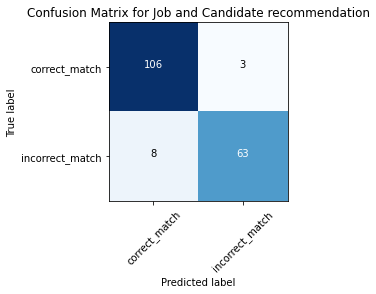

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       109
           1       0.95      0.89      0.92        71

    accuracy                           0.94       180
   macro avg       0.94      0.93      0.94       180
weighted avg       0.94      0.94      0.94       180



In [22]:
# Create a confusion matrix to gauge the accuracy of our model.
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# confusion matrix.
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)


# function to plot our confusion metrics copied from sktlearn.
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion metrix.
    Normalization can be applied by by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# plot are confusion matrix.
cm_plot_labels = ['correct_match', 'incorrect_match']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix for Job and Candidate recommendation')

# calculate some import component from our matrix.
"""
Precision,
Recall,
f1-score,
support
"""
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))